In [6]:
import os
import cv2 as cv
import nibabel as nib
import numpy as np
import concurrent.futures
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, recall_score, precision_score, confusion_matrix
from tqdm import tqdm
from PIL import Image
import logging
import torch
import torchvision.transforms as transforms
# import torch_xla
# import torch_xla.core.xla_model as xm

print

In [7]:
def calculate_metrics(true_mask, pred_mask):
        # Confusion Matrix
        cm = confusion_matrix(true_mask, pred_mask, labels=[0, 1])
        # True Negative Rate (Specificity)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
        # Dice coefficient
        dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0.0
        # Sensitivity (Recall)
        sensitivity = recall_score(true_mask, pred_mask, labels=[0, 1], average="binary", zero_division=1)
        # Precision
        precision = precision_score(true_mask, pred_mask, labels=[0, 1], average="binary", zero_division=1)
        # Accuracy
        acc_value = accuracy_score(true_mask, pred_mask)
        # F1 Score
        f1_value = f1_score(true_mask, pred_mask, labels=[0, 1], average="binary",zero_division=1)
        # Jaccard Score
        jacc_value = jaccard_score(true_mask, pred_mask, labels=[0, 1], average="binary",zero_division=1)

        return specificity, dice, sensitivity, precision, acc_value, f1_value, jacc_value

In [8]:
images=[]
true_masks=[]
pred_masks=[]

In [9]:
image_paths=os.listdir("../3d images/eval/data")
true_mask_paths=os.listdir("../3d images/eval/label")
print(image_paths)
print(true_mask_paths)
for image_path,mask_path in zip(image_paths,true_mask_paths):

    image=cv.imread(os.path.join("../3d images/eval/data",image_path),cv.IMREAD_GRAYSCALE)
    mask=cv.imread(os.path.join("../3d images/eval/label",mask_path),cv.IMREAD_GRAYSCALE)
    images.append(image)
    true_masks.append(mask)


['data_patch_199712.png', 'data_patch_199713.png', 'data_patch_199714.png', 'data_patch_199715.png', 'data_patch_199716.png', 'data_patch_199717.png', 'data_patch_199718.png', 'data_patch_199719.png', 'data_patch_199720.png', 'data_patch_199721.png']
['label_patch_199712.png', 'label_patch_199713.png', 'label_patch_199714.png', 'label_patch_199715.png', 'label_patch_199716.png', 'label_patch_199717.png', 'label_patch_199718.png', 'label_patch_199719.png', 'label_patch_199720.png', 'label_patch_199721.png']


In [10]:
def single_image_inference(image, model, device):
   
    transform = transforms.Compose([
         transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])
   
    img = transform(image).float().to(device)
    img = img.unsqueeze(0)

    with torch.no_grad():
        pred_mask = model(img)

        pred_mask = pred_mask.squeeze(0).cpu().permute(1, 2, 0)
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1

        return pred_mask.numpy()

In [21]:
from unet import UNet


device = torch.device('cpu')

model = UNet(in_channels=1, num_classes=1).to(device)

model.load_state_dict(torch.load("../models/Single_SpineSegmentationv6.pth", map_location={"cpu":"cpu"}))

model.eval()

for image in images:
  
  pred_mask=single_image_inference(image, model, device)
  pred_masks.append(pred_mask)




NotImplementedError: Could not run 'aten::empty.memory_format' with arguments from the 'XLA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::empty.memory_format' is only available for these backends: [CPU, Meta, QuantizedCPU, QuantizedMeta, MkldnnCPU, SparseCPU, SparseMeta, SparseCsrCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterCPU.cpp:31357 [kernel]
Meta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterMeta.cpp:26984 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterQuantizedCPU.cpp:944 [kernel]
QuantizedMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterQuantizedMeta.cpp:105 [kernel]
MkldnnCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterMkldnnCPU.cpp:515 [kernel]
SparseCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterSparseCPU.cpp:1387 [kernel]
SparseMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterSparseMeta.cpp:249 [kernel]
SparseCsrCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterSparseCsrCPU.cpp:1135 [kernel]
BackendSelect: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterBackendSelect.cpp:807 [kernel]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\NegateFallback.cpp:23 [kernel]
ZeroTensor: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:90 [kernel]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradHIP: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradIPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradVE: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradMTIA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradPrivateUse1: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradPrivateUse2: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradPrivateUse3: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
AutogradNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19039 [autograd kernel]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\TraceType_2.cpp:17346 [kernel]
AutocastCPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:720 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:158 [backend fallback]


In [ ]:
print(pred_masks[0].shape)

(128, 128, 1)


C:\Users\hp\AppData\Local\Temp\ipykernel_2944\3958078249.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)  # Adjust the subplot layout


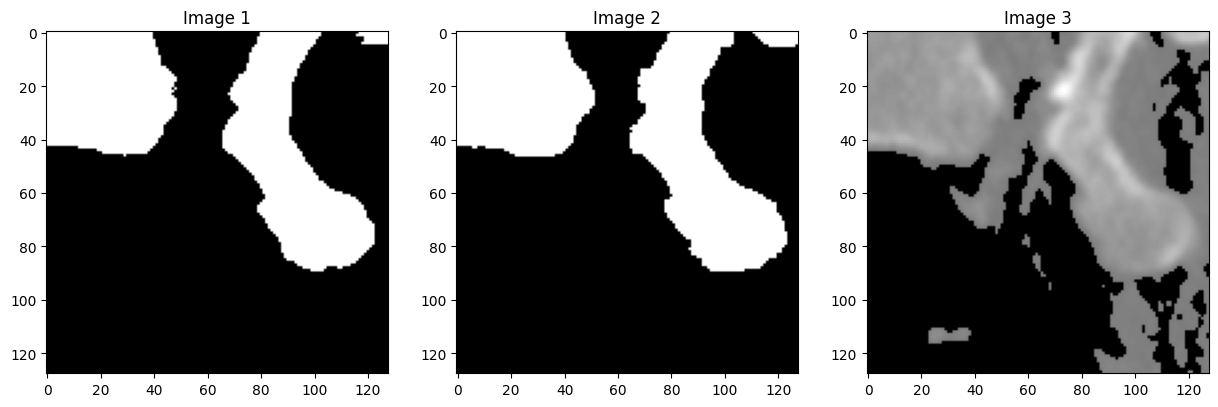

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15, 5))  # Adjust the figsize as needed
plt.axis('off')

plt.subplot(1, 3, 1)  # Adjust the subplot layout
plt.imshow(pred_masks[3], cmap='gray')  # Assuming grayscale images
plt.title('Image 1')

plt.subplot(1, 3, 2)
plt.imshow(true_masks[3], cmap='gray')  # Assuming grayscale images
plt.title('Image 2')

plt.subplot(1, 3, 3)
plt.imshow(images[3], cmap='gray')  # Assuming grayscale images
plt.title('Image 3')

plt.show()



In [ ]:
def evaluate_metrics():
        print("calculating matrices ...............")
        specificity_scores = []
        dice_scores = []
        sensitivity_scores = []
        precision_scores = []
        f1_scores = []
        jacc_scores = []
        accuracy_scores = []

        for true_mask, pred_mask in tqdm(zip(true_masks,pred_masks)):
            pred_mask = pred_mask / 255.0
            pred_mask = (pred_mask > 0.5).astype(np.int32)
            pred_mask = pred_mask.flatten()

            true_mask = true_mask / 255.0
            true_mask = (true_mask > 0.5).astype(np.int32)
            true_mask = true_mask.flatten()

            specificity, dice, sensitivity, precision, acc_value, f1_value, jacc_value = calculate_metrics(
                true_mask, pred_mask)

            sensitivity_scores.append(sensitivity)
            dice_scores.append(dice)
            specificity_scores.append(specificity)
            precision_scores.append(precision)
            accuracy_scores.append(acc_value)
            f1_scores.append(f1_value)
            jacc_scores.append(jacc_value)

        # Calculate mean scores
        mean_sensitivity = np.mean(sensitivity_scores)
        mean_dice = np.mean(dice_scores)
        mean_specificity = np.mean(specificity_scores)
        mean_precision = np.mean(precision_scores)
        mean_accuracy = np.mean(accuracy_scores)
        mean_f1 = np.mean(f1_scores)
        mean_jacc = np.mean(jacc_scores)

        # Log scores
        logging.basicConfig(filename='score.log', level=logging.INFO)
        logging.info(f'Mean Sensitivity: {mean_sensitivity}')
        logging.info(f'Mean Dice: {mean_dice}')
        logging.info(f'Mean Specificity: {mean_specificity}')
        logging.info(f'Mean Precision: {mean_precision}')
        logging.info(f'Mean Accuracy: {mean_accuracy}')
        logging.info(f'Mean F1: {mean_f1}')
        logging.info(f'Mean Jaccard: {mean_jacc}')

        # Optionally, you can also log the individual arrays
        logging.info(f'Sensitivity Scores: {sensitivity_scores}')
        logging.info(f'Dice Scores: {dice_scores}')
        logging.info(f'Specificity Scores: {specificity_scores}')
        logging.info(f'Precision Scores: {precision_scores}')
        logging.info(f'Accuracy Scores: {accuracy_scores}')
        logging.info(f'F1 Scores: {f1_scores}')
        logging.info(f'Jaccard Scores: {jacc_scores}')

In [ ]:
evaluate_metrics()

calculating matrices ...............


10it [00:00, 22.57it/s]
